In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer

from sklearn import svm, tree

In [2]:
#Import data and give column names

train = pd.read_csv('../../data/feature_selected_train_FD001.csv', sep=',', header=0, engine='python')
test = pd.read_csv('../../data/feature_selected_test_FD001.csv', sep=',', header=0, engine='python')
y_test = pd.read_csv('../../data/RUL_FD001.csv', sep=',', header=0,  engine='python')

index_names = train.columns[[0, 1]]
setting_names = train.columns[[2]]
sensor_names = train.drop(index_names.union(setting_names), axis = 1).columns # Find something better than union!!
scale_columns = sensor_names
keep_columns = scale_columns.union(index_names[[1]])

In [3]:
def scale_data(train, test, columns):
    sc = MinMaxScaler()
    scaled_train = train.copy()
    scaled_test = test.copy()
    scaled_train[columns] = pd.DataFrame(sc.fit_transform(scaled_train[columns]))
    scaled_test[columns] = pd.DataFrame(sc.transform(scaled_test[columns]))
    return scaled_train, scaled_test

def add_remaining_useful_life(df):
    grouped_by_unit = df.groupby(by="unit_no")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_no', right_index=True)
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
def plot_loss(history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label='train')
    plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate(y_true, y_hat, label):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
    
def plot_predictions(y_true, y_predicted):
    plt.figure(figsize=(13,5))
    plt.plot(y_true, label='true')
    plt.plot(y_predicted, label='predicted')
    plt.xlabel('Predictions')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

In [4]:
x_train = add_remaining_useful_life(train)
y_train = x_train.pop('RUL')
x_test = test.groupby(by="unit_no").last().reset_index()
x_train_scaled, x_test_scaled = scale_data(x_train, x_test, scale_columns)

In [8]:
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

In [9]:
if False:
    reg_grid = tree.DecisionTreeRegressor()
    svm_grid = GridSearchCV(reg_grid, parameters, 
                            scoring = make_scorer(mean_squared_error, greater_is_better = False), 
                            verbose = 10).fit(x_train_scaled, y_train)
    svm_grid.best_params_

In [22]:
reg = tree.DecisionTreeRegressor(random_state = 1, max_depth = 2, max_features = 'log2', max_leaf_nodes= 30, min_samples_leaf= 7, min_weight_fraction_leaf= 0.2, splitter='random')
reg.fit(x_train_scaled, y_train)
y_hat_train = reg.predict(x_train_scaled)
evaluate(y_train, y_hat_train, 'Train')

y_hat_test = reg.predict(x_test_scaled)
evaluate(y_test, y_hat_test, 'Test')

Train set RMSE:57.697526102168126, R2:0.298323918681912
Test set RMSE:44.42168871288248, R2:-0.14269567783475434


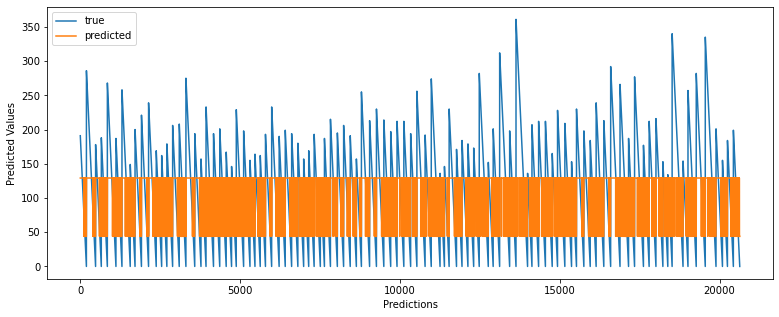

In [13]:
plot_predictions(y_train, y_hat_train)

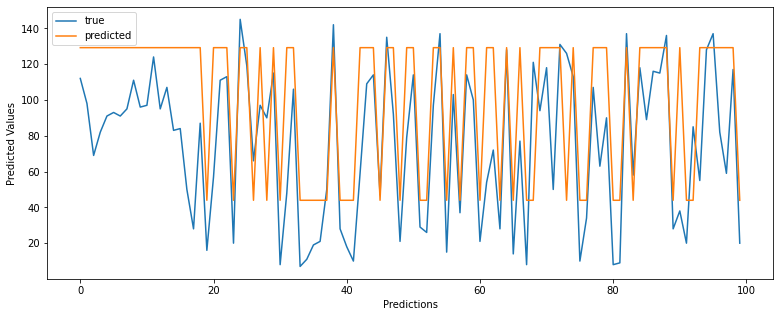

In [14]:
plot_predictions(y_test, y_hat_test)